In [2]:
#Load Libraries
from sklearn.model_selection import train_test_split
import numpy as np
import math 
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt 
import time
from sklearn.svm import OneClassSVM
%matplotlib inline

#Load dataset
data = np.genfromtxt('House1Sample.csv', delimiter=',')


Text(0, 0.5, 'Energy Consumption (kWh)')

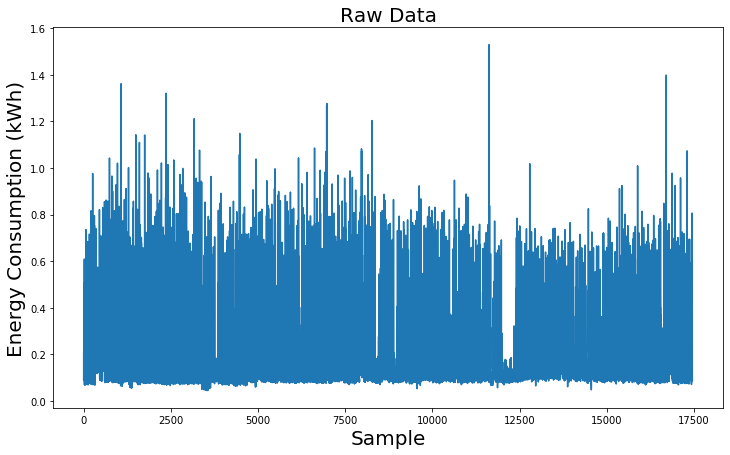

In [5]:
plt.figure(figsize=(12,7))
plt.plot(range(len(data)),data)
plt.title("Raw Data",fontsize=20)
plt.xlabel("Sample",fontsize=20)
plt.ylabel("Energy Consumption (kWh)",fontsize=20)

# Moving Average

In [7]:
window_size = 48*14 #48 Samples is a day
i = 0
moving_averages_14 = []
#Calculate moving average
while i < len(data) - window_size + 1:
    window = data[i : i + window_size]
    window_average = sum(window) / window_size
    moving_averages_14.append(window_average)
    i += 1
window_plot_14=[i for i in range(671,len(data))] #For plotting the moving average

Text(0.5, 1.0, '14 Day Moving Average')

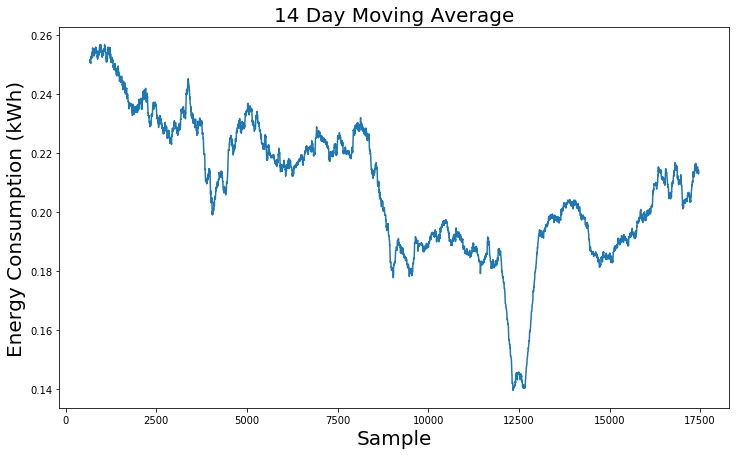

In [8]:
plt.figure(figsize=(12,7))
plt.plot(window_plot_14,moving_averages_14)
plt.xlabel("Sample",fontsize=20)
plt.ylabel("Energy Consumption (kWh)",fontsize=20)
plt.title("14 Day Moving Average",fontsize=20)

# Power martingale

In [6]:
SVM=OneClassSVM()
#Reshape data for one class svm
data_re=data.reshape(-1,1)
#Initialize variable for storage
p_values=np.append(1,np.zeros(len(data_re)-1))
bet=np.append(1,np.zeros(len(data_re)-1))
online_X_train=data_re[0]

epsilon=0.92 
N=len(data_re)
C=10**4 #Threshold value
i=0
sigma=[0] #List of indices of detected anomalies
M=[1] #Initialize martingale value


for n in range(1,N):
    #Take sequence of data samples from last anomaly detected to n
    seq=data_re[sigma[i]+1:n+1]
    if len(seq)==1: #p-value for a sequence of length one is equal to one
        score=1
        p_values[n]=score
    else:
        #Calculate p-value for test sample based on sequence
        SVM.fit(seq)
        d_func=SVM.decision_function(seq)
        score=-1*d_func
        p_values[n]=np.mean(score>=score[-1])

    #Calculate output of betting function for p-value    
    bet[n]=epsilon * (p_values[n] ** (epsilon - 1))
    #Martingale is the product of all previous betting functions from last anomaly detected to n
    Mn=np.prod(bet[sigma[i]+1:n+1])
    M=np.append(M,Mn)
    
    #If the martingale value reaches the threshold record its indices
    if Mn>C:
        i=i+1
        sigma=np.append(sigma,n)

Text(0.5, 1.0, ' Power Martingale - Threshold = $10^4$')

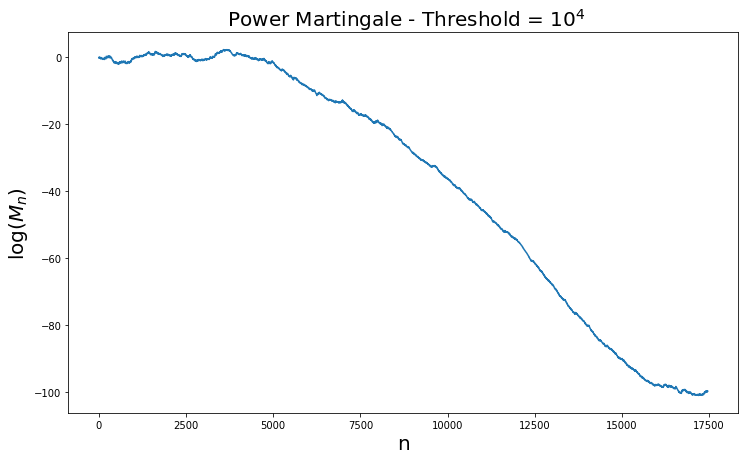

In [11]:
plt.figure(figsize=(12,7))
plt.plot(range(len(M)),np.log10(M))
plt.xlabel("n",fontsize=20)
plt.ylabel("log($M_n$)",fontsize=20)
plt.title(" Power Martingale - Threshold = $10^4$",fontsize=20)